In [1]:
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import glob

In [4]:
# add perplexity of segments and then drop the log prob
get_marker_indices = lambda logproblist, special_char: [i for i, x in enumerate(logproblist) if special_char in [i for i in x.values()][0]["decoded_token"]]
segment_logprobs = lambda logproblist,a,b: [[i for i in logproblist[idx].values()][0]["logprob"] for idx in range(a,b+1)]
calc_ppl = lambda logprobs: np.exp(-np.sum(logprobs)/len(logprobs))

def get_perplexities(example, special_char="*", in_context=True):
    marker_indices = get_marker_indices(example, special_char)

    if in_context:
        segment_a_indices = marker_indices[2], marker_indices[3]
        segment_b_indices = marker_indices[4], marker_indices[5]
    else:
        segment_a_indices = marker_indices[0], marker_indices[1]
        segment_b_indices = marker_indices[2], marker_indices[3]
    
    if in_context:
        excerpt_ppl = calc_ppl(segment_logprobs(example, marker_indices[0], marker_indices[1]))
    else:
        excerpt_ppl = -1
        
    segA_ppl = calc_ppl(segment_logprobs(example, segment_a_indices[0], segment_a_indices[1]))
    segB_ppl = calc_ppl(segment_logprobs(example, segment_b_indices[0], segment_b_indices[1]))
    
    return excerpt_ppl, segA_ppl, segB_ppl

def add_perplexities(dataframe, special_char="*", in_context=True):
    """
    Given a dataframe from our experiment, add perplexities for the excerpt and both segment A and segment B.
    
    This is done based on special character markers that mark the beginning of both the excerpts and the segments.
    In our experiment this was "*".
    """
    dataframe["ppl"] = dataframe["prompt_logprob_json"].apply( func=lambda x: get_perplexities(json.loads(x), special_char, in_context))
    dataframe["excerpt_perplexity"] = dataframe["ppl"].apply(lambda x: x[0])
    dataframe["segment_A_perplexity"] = dataframe["ppl"].apply(lambda x: x[1])
    dataframe["segment_B_perplexity"] = dataframe["ppl"].apply(lambda x: x[2])
    return dataframe

In [2]:
# Set the path to your folder
folder_path = 'all'

# Get a list of all CSV files in the folder
csv_files = glob.glob(folder_path + '\\*.csv')

# Read all CSV files into a list of DataFrames
dfs = [pd.read_csv(file) for file in csv_files]

# Concatenate the DataFrames row-wise
df_concat = pd.concat(dfs, ignore_index=True)

df = add_perplexities(df_concat, in_context=False)
df = df.drop("prompt_logprob_json",axis=1)
df["correct"] = df["answer"].map({"A":1,"B":0}) == df["A_is_first"]
#df.to_csv('mistral-v2-7b-instruct-finetuned.csv', index=False)

In [100]:
instruction_only = [ x for x in df["model_name"].unique() if "instruction-only" in x ]
book_text = [ x for x in df["model_name"].unique() if not "instruction-only" in x ]

mistral_segA_ppl_instruction_only = [df[df["model_name"] == name]["segment_A_perplexity"].mean() for name in instruction_only]
mistral_segB_ppl_instruction_only = [df[df["model_name"] == name]["segment_B_perplexity"].mean() for name in instruction_only]
mistral_segA_ppl_book_text = [df[df["model_name"] == name]["segment_A_perplexity"].mean() for name in book_text]
mistral_segB_ppl_book_text = [df[df["model_name"] == name]["segment_B_perplexity"].mean() for name in book_text]

mistral_accuracy_instruction_only = [df[df["model_name"] == name]["correct"].mean() for name in instruction_only]
mistral_accuracy_book_text = [df[df["model_name"] == name]["correct"].mean() for name in book_text]

In [101]:
df_llama = pd.read_csv("finetuned_llama3-8b.csv")

instruction_only = [ x for x in df_llama["model_name"].unique() if "instruction-only" in x and not "summaries" in x]
book_text = [ x for x in df_llama["model_name"].unique() if not "instruction-only" in x and not "summaries" in x][1:]

llama3_8b_segA_ppl_instruction_only = [df_llama[df_llama["model_name"] == name]["segment_A_perplexity"].mean() for name in instruction_only]
llama3_8b_segB_ppl_instruction_only = [df_llama[df_llama["model_name"] == name]["segment_B_perplexity"].mean() for name in instruction_only]
llama3_8b_segA_ppl_book_text = [df_llama[df_llama["model_name"] == name]["segment_A_perplexity"].mean() for name in book_text]
llama3_8b_segB_ppl_book_text = [df_llama[df_llama["model_name"] == name]["segment_B_perplexity"].mean() for name in book_text]

llama3_8b_accuracy_instruction_only = [df_llama[df_llama["model_name"] == name]["correct"].mean() for name in instruction_only]
llama3_8b_accuracy_book_text = [df_llama[df_llama["model_name"] == name]["correct"].mean() for name in book_text]

# Perplexity is decreasing with fine-tuning

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


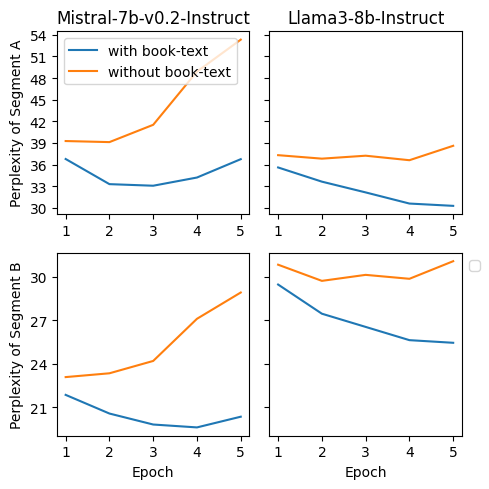

In [123]:
x = np.arange(1,6)
fig, axs = plt.subplots(2, 2, figsize=(5, 5), sharey="row")
axs[0,0].plot(x, mistral_segA_ppl_book_text, label='with book-text')
axs[0,0].plot(x, mistral_segA_ppl_instruction_only, label=r'without book-text')  # use Blues colormap to choose similar color
axs[1,0].plot(x, mistral_segB_ppl_book_text, label=r'with book-text')
axs[1,0].plot(x, mistral_segB_ppl_instruction_only, label=r'without book-text')  # use same color as above
axs[0,0].legend()

axs[0,1].plot(x, llama3_8b_segA_ppl_book_text)
axs[0,1].plot(x, llama3_8b_segA_ppl_instruction_only)  # use Blues colormap to choose similar color
axs[1,1].plot(x, llama3_8b_segB_ppl_book_text)
axs[1,1].plot(x, llama3_8b_segB_ppl_instruction_only)  # use same color as above
axs[0,1].set_title("Llama3-8b-Instruct")
axs[0,0].set_title("Mistral-7b-v0.2-Instruct")

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
axs[0,0].set_ylabel('Perplexity of Segment A')
axs[1,0].set_ylabel('Perplexity of Segment B')

for a in axs.flat:
    a.yaxis.set_major_locator(MultipleLocator(base=3))
    a.set_xticks(x)
axs[1,0].set_xlabel("Epoch")
axs[1,1].set_xlabel("Epoch")

plt.tight_layout()
plt.savefig("perplexity_finetuning.pdf")

# Accuracy is not increasing with fine-tuning.

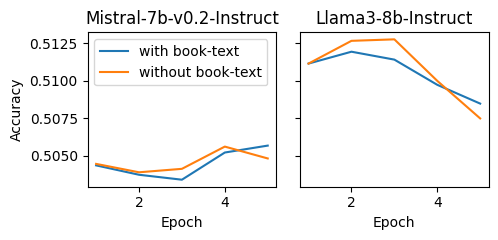

In [129]:
x = np.arange(1,6)
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5), sharey="row")

# mistral 7b v0.2
axs[0].plot(x, mistral_accuracy_book_text, label=r'with book-text')  # use Blues colormap to choose similar color
axs[0].plot(x, mistral_accuracy_instruction_only, label=r'without book-text')

# mistral 7b v0.2
axs[1].plot(x, llama3_8b_accuracy_book_text, label=r'with book-text')  # use Blues colormap to choose similar color
axs[1].plot(x, llama3_8b_accuracy_instruction_only, label=r'without book-text')

axs[1].set_title("Llama3-8b-Instruct")
axs[0].set_title("Mistral-7b-v0.2-Instruct")

axs[0].set_xlabel("Epoch")
axs[0].legend(loc="upper left")
axs[1].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
plt.tight_layout()
plt.savefig("accuracy_finetuning.pdf")

# Statistical Analyses

We show that performance is not different between the models fine-tuned on the books (including 3,500 unrelated instruction samples to prevent catastrophic forgetting) vs the models fine-tuned with only the instruction data.

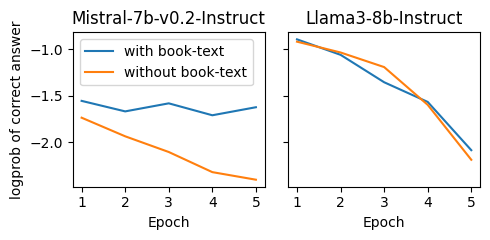

In [202]:
df["p_correct"] = df.apply(lambda row: row["prob_A"] if row["A_is_first"] == 1 else row["prob_B"], axis=1)
df_llama["p_correct"] = df_llama.apply(lambda row: row["prob_A"] if row["A_is_first"] == 1 else row["prob_B"], axis=1)

llama3_8b_p_correct_book_text = [df_llama[df_llama["model_name"] == n]["p_correct"].mean() for n in [x for x in model_names_llama if not "instruction-only" in x]]
llama3_8b_p_correct_instruction_only = [df_llama[df_llama["model_name"] == n]["p_correct"].mean() for n in [x for x in model_names_llama if "instruction-only" in x]]

mistral_p_correct_book_text = [df[df["model_name"] == n]["p_correct"].mean() for n in [x for x in df["model_name"].unique() if not "instruction-only" in x]]
mistral_p_correct_instruction_only = [df[df["model_name"] == n]["p_correct"].mean() for n in [x for x in df["model_name"].unique() if "instruction-only" in x]]

x = np.arange(1,6)
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5), sharey="row")

# mistral 7b v0.2
axs[0].plot(x, mistral_p_correct_book_text, label=r'with book-text')  # use Blues colormap to choose similar color
axs[0].plot(x, mistral_p_correct_instruction_only, label=r'without book-text')

# mistral 7b v0.2
axs[1].plot(x, llama3_8b_p_correct_book_text, label=r'with book-text')  # use Blues colormap to choose similar color
axs[1].plot(x, llama3_8b_p_correct_instruction_only, label=r'without book-text')

axs[1].set_title("Llama3-8b-Instruct")
axs[0].set_title("Mistral-7b-v0.2-Instruct")

axs[0].set_xlabel("Epoch")
axs[0].legend(loc="upper left")
axs[1].set_xlabel("Epoch")
axs[0].set_ylabel("logprob of correct answer")

axs[0].set_xticks(x)
axs[1].set_xticks(x)
plt.tight_layout()

plt.savefig("p_correct_finetuning.pdf")


In [171]:
# COMPLETE DATA, not separated into distance bins and segment lengths
from statsmodels.stats.contingency_tables import mcnemar
import scipy
books = [69087, 72578, 72600, 72869, 72958, 72972, 73017, 73042]

def get_mcnemar_ttest(df, model_names):

    df["p_correct"] = df.apply(lambda row: row["prob_A"] if row["A_is_first"] == 1 else row["prob_B"], axis=1)
    df["p_correct_relative"] = np.log(np.exp(df["p_correct"])/(np.exp(df["prob_A"])+np.exp(df["prob_B"])))
    mcnemar_matrices = np.zeros((len(model_names), len(model_names)))
    pairwise_ttest_matrices = np.zeros((len(model_names), len(model_names)))
    for i in range(len(model_names)):
        for j in range(len(model_names)):
            model_name_1 = model_names[i]
            model_name_2 = model_names[j]

            df["book_in_list"] = df["book_idx"].apply(lambda x: True if x in books else False)
            model_1 = df[(df["model_name"]==model_name_1) &(df["book_in_list"] == True)]
            model_2 = df[(df["model_name"]==model_name_2) &(df["book_in_list"] == True)]
            
            assert len(model_1) == len(model_2), f"Need to have the same number of observations for both models. Got {len(model_1)} and {len(model_2)}"
            # McNemar's Test for correctness
            m1_vals = model_1["correct"].values
            m2_vals = model_2["correct"].values
            assert len(m1_vals) == len(m2_vals), "groups have different amounts of samples in this bin"
            both_correct = sum((m1_vals)&(m2_vals))
            m1_correct_m2_incorrect = sum((m1_vals)&(~m2_vals))
            m2_correct_m1_incorrect = sum((m2_vals)&(~m1_vals))
            both_incorrect =  sum((~m2_vals)&(~m1_vals))
            contingency_table = np.array([[both_correct, m1_correct_m2_incorrect],[m2_correct_m1_incorrect, both_incorrect]])
            result = mcnemar(contingency_table, exact=False)
            mcnemar_matrices[i,j] = result.pvalue
    
            # pairwise t-test for log probability of the correct answer
            m1_vals = model_1["p_correct_relative"].values
            m2_vals = model_2["p_correct_relative"].values
        
            assert len(m1_vals) == len(m2_vals), "groups have different amounts of samples in this bin"
            result = scipy.stats.ttest_rel(m1_vals, m2_vals,alternative="greater")
            pairwise_ttest_matrices[i,j] = result.pvalue
    return mcnemar_matrices, pairwise_ttest_matrices

model_names = df["model_name"].unique()
mistral_mcnemar_matrices, mistral_pairwise_ttest_matrices = get_mcnemar_ttest(df, model_names)

C:\Users\Mathis\anaconda3\envs\memory_evaluation\Lib\site-packages\statsmodels\stats\contingency_tables.py:1348: RuntimeWarning: divide by zero encountered in scalar divide
  statistic = (np.abs(n1 - n2) - corr)**2 / (1. * (n1 + n2))


In [165]:
model_names_llama = [x for x in df_llama["model_name"].unique()[1:] if not "summaries" in x]

In [174]:
model_names_llama = ['llama3-8b-finetune-v4-1-instruction-only', 
                     'llama3-8b-finetune-v4-1', 
                     'llama3-8b-finetune-v4-2-instruction-only', 
                     'llama3-8b-finetune-v4-2', 
                     'llama3-8b-finetune-v4-3-instruction-only',
                     'llama3-8b-finetune-v4-3',
                     'llama3-8b-finetune-v4-4-instruction-only',
                      'llama3-8b-finetune-v4-4',
                     'llama3-8b-finetune-v4-5-instruction-only',
                     'llama3-8b-finetune-v4-5']

llama3_8b_mcnemar_matrices, llama3_8b_pairwise_ttest_matrices = get_mcnemar_ttest(df_llama, model_names_llama)

C:\Users\Mathis\anaconda3\envs\memory_evaluation\Lib\site-packages\statsmodels\stats\contingency_tables.py:1348: RuntimeWarning: divide by zero encountered in scalar divide
  statistic = (np.abs(n1 - n2) - corr)**2 / (1. * (n1 + n2))


In [194]:
model_names = ["Epoch 1 (without books)", "Epoch 1 (with books)", "Epoch 2 (without books)", "Epoch 2 (with books)", "Epoch 3 (without books)", "Epoch 3 (with books)", "Epoch 4 (without books)", "Epoch 4 (with books)", "Epoch 5 (without books)", "Epoch 5 (with books)"]

def plot_mcnemar_ttest(mcnemar_matrices, pairwise_ttest_matrices, model_names, name="test"):
    
    plt.figure(figsize=(20*0.4,16*0.4))
    plt.subplots_adjust(left=0.25, right=1, top=0.95, bottom=0.3)
    sns.heatmap(mcnemar_matrices, cmap="coolwarm",annot=True,fmt=".2f", center=0.001)
    plt.xticks(np.arange(0,len(model_names)), model_names, rotation=67)
    plt.yticks(np.arange(0,len(model_names)), model_names, rotation=0)
    #plt.title(f"P-values from McNemar's pairwise statistical test on LTM-condition outcomes")
    #plt.title(f"McNemar test matrix {name}")
    
    plt.savefig(f"McNemar_matrix_{name}.pdf")
    
    plt.close()
    
    plt.figure(figsize=(20*0.4,16*0.4))
    plt.subplots_adjust(left=0.25, right=1, top=0.95, bottom=0.3)
    sns.heatmap(pairwise_ttest_matrices, cmap="coolwarm",annot=True,fmt=".2f", center=0.001)
    plt.xticks(np.arange(0,len(model_names)), model_names, rotation=67)
    plt.yticks(np.arange(0,len(model_names)), model_names, rotation=0)
    #plt.title(f"P-values from a pairwise t-test on LTM-condition log-probabilities of the correct answer")
    #plt.title(f"Pairwise t-test matrix {name}")
    #plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.15)
    plt.savefig(f"pairwise-ttest_matrix_{name}.pdf")
    plt.close()

plot_mcnemar_ttest(mistral_mcnemar_matrices, mistral_pairwise_ttest_matrices, model_names, name="Mistral-7b-v0.2-Instruct")
plot_mcnemar_ttest(llama3_8b_mcnemar_matrices, llama3_8b_pairwise_ttest_matrices, model_names, name="Llama3-8b-Instruct")